# Statoil/C-CORE Iceberg Classifier Challenge

Identifies if a remotely sensed target is a ship or iceberg.

## Project: Build a Iceberg Classifier using Deep Learning

[Kaggle Statoil Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)


In [1]:
import pandas as pd 
import numpy as np 
import cv2 # Used to manipulated the images 
np.random.seed(1337) # The seed I used - pick your own or comment out for a random seed. A constant seed allows for better comparisons though

# Import Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
df_test = pd.read_json('../data/test.json')
df_test.inc_angle = df_test.inc_angle.replace('na',0)

In [3]:
df_train = pd.read_json('../data/train.json') # this is a dataframe

In [4]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

In [5]:
Xtrain = get_scaled_imgs(df_train)

In [6]:
Ytrain = np.array(df_train['is_iceberg'])

In [7]:
df_train.inc_angle = df_train.inc_angle.replace('na',0)
idx_tr = np.where(df_train.inc_angle>0)

In [8]:
Ytrain = Ytrain[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]

In [9]:
def get_more_images(images):
    
    image_rot90 = []
    image_rot180 = []
    image_rot270 = []
    image_mirror_lr = []
    image_mirror_ud = []
    for i in range(0,images.shape[0]):
        band_1 = images[i,:,:,0]
        band_2 = images[i,:,:,1]
        band_3 = images[i,:,:,2]
        
        # rotate 90
        band_1_rot90 = np.rot90(band_1)
        band_2_rot90 = np.rot90(band_2)
        band_3_rot90 = np.rot90(band_3)
        image_rot90.append(np.dstack((band_1_rot90, band_2_rot90, band_3_rot90)))
        
        # rotate 180
        band_1_rot180 = np.rot90(band_1_rot90)
        band_2_rot180 = np.rot90(band_2_rot90)
        band_3_rot180 = np.rot90(band_3_rot90)
        image_rot180.append(np.dstack((band_1_rot180, band_2_rot180, band_3_rot180)))
        
        # rotate 270
        band_1_rot270 = np.rot90(band_1_rot180)
        band_2_rot270 = np.rot90(band_2_rot180)
        band_3_rot270 = np.rot90(band_3_rot180)
        image_rot270.append(np.dstack((band_1_rot270, band_2_rot270, band_3_rot270)))
        
        # mirror left-right
        band_1_mirror_lr = np.flip(band_1, 0)
        band_2_mirror_lr = np.flip(band_2, 0)
        band_3_mirror_lr = np.flip(band_3, 0)
        image_mirror_lr.append(np.dstack((band_1_mirror_lr, band_2_mirror_lr, band_3_mirror_lr)))
        
        # mirror up-down
        band_1_mirror_ud = np.flip(band_1, 1)
        band_2_mirror_ud = np.flip(band_2, 1)
        band_3_mirror_ud = np.flip(band_3, 1)
        image_mirror_ud.append(np.dstack((band_1_mirror_ud, band_2_mirror_ud, band_3_mirror_ud)))
        
    rot90 = np.array(image_rot90)
    rot180 = np.array(image_rot180)
    rot270 = np.array(image_rot270)
    mirrorlr = np.array(image_mirror_lr)
    mirrorud = np.array(image_mirror_ud)
    images = np.concatenate((images, rot90, rot180, rot270, mirrorlr, mirrorud))
    
    return images

In [10]:
Xtr_more = get_more_images(Xtrain) 

In [11]:
Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain,Ytrain,Ytrain,Ytrain))

In [12]:
def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [13]:
model = getModel()
model.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('../models/model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [ ]:
timeline=model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=500, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.1)


Train on 7943 samples, validate on 883 samples
Epoch 1/500
 928/7943 [==>...........................] - ETA: 4:32 - loss: 0.1380 - acc: 0.9494

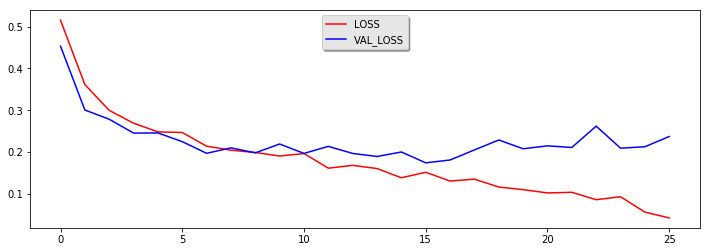

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,4))

plt.plot(timeline.history['loss'], color='red', label='LOSS')
plt.plot(timeline.history['val_loss'], color='blue', label='VAL_LOSS')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

In [16]:
model.load_weights(filepath = '../models/model.hdf5')

score = model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

1471/1471 [==============================] - 16s 11ms/step
Train score: 0.0922721945342
Train accuracy: 0.970088374647


In [17]:
Xtest = (get_scaled_imgs(df_test))
pred_test = model.predict(Xtest)

submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission)


            id    is_iceberg
0     5941774d  4.945528e-03
1     4023181e  9.999752e-01
2     b20200e4  8.458320e-01
3     e7f018bb  9.999759e-01
4     4371c8c3  1.000000e+00
5     a8d9b1fd  2.528828e-01
6     29e7727e  1.379810e-02
7     92a51ffb  9.999992e-01
8     c769ac97  5.243951e-05
9     aee0547d  6.319467e-06
10    565b28ac  9.354751e-10
11    e04e9775  9.999983e-01
12    8e8161d1  3.386558e-05
13    4cf4d256  9.999999e-01
14    139e5324  9.997975e-01
15    f156976f  6.890502e-03
16    68a117cc  9.829464e-01
17    d9aa7a56  7.359630e-04
18    9005b143  9.797641e-01
19    5f6d3988  9.999942e-01
20    9ad70954  1.000000e+00
21    b9087b9e  9.996425e-02
22    a39a1427  1.232398e-01
23    82fbe8ed  2.333231e-02
24    1fae4879  6.476850e-08
25    6dd8f13d  5.348264e-04
26    bbad5958  1.557390e-01
27    54527583  9.998732e-01
28    be8fa29c  9.984756e-01
29    81a3328f  9.999430e-01
...        ...           ...
8394  8ae30ce6  4.483581e-04
8395  de27ed88  1.840067e-04
8396  66d5196f

In [18]:
submission.to_csv('../submission/submission10.csv', index=False)